In [1]:
import numpy as np
a = np.array([
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ] )
size = a.shape[0]

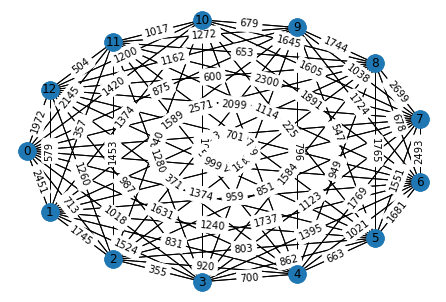

In [2]:
# 邻接矩阵构造的完全图
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph(a)

def draw_with_labels(G, pos=nx.spring_layout(G)):
  nx.draw(G,pos)
  nx.draw(G, pos, with_labels=True)
  labels = nx.get_edge_attributes(G,'weight')
  nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
  plt.show()
draw_with_labels(G, nx.shell_layout(G))

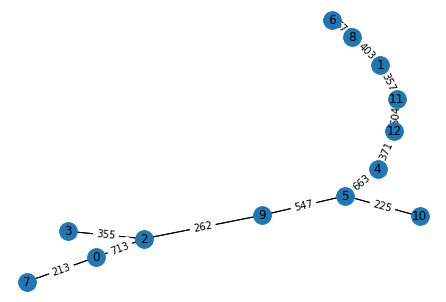

In [3]:
# 最小生成树
T = nx.minimum_spanning_tree(G)
draw_with_labels(T, nx.spring_layout(T))

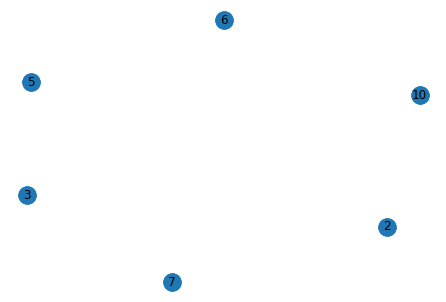

In [4]:
# 最小生成树的奇数顶点
O = nx.Graph()
for node, degree in nx.degree(T):
    if(degree % 2 == 1):
        O.add_node(node)
draw_with_labels(O, nx.spring_layout(O))

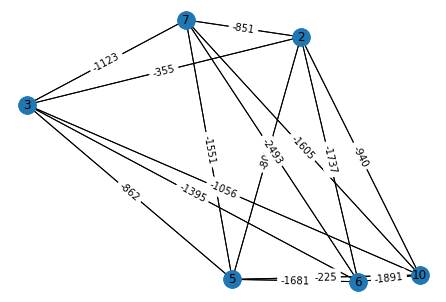

In [11]:
# 最小生成树奇度顶点的生成子图
node_with_weights = list()
for nodes, weight in dict(nx.get_edge_attributes(G, 'weight')).items():
    if nodes[0] in O.nodes() and nodes[1] in O.nodes():
        node_with_weights.append((nodes[0], nodes[1], -1*weight))
O.add_weighted_edges_from(node_with_weights, weight='weight')
draw_with_labels(O, nx.spring_layout(O))

[(2, 7, 851), (3, 6, 1395), (5, 10, 225)]


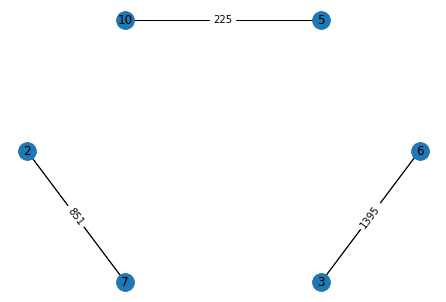

In [6]:
from __future__ import print_function

# If assigned, DEBUG(str) is called with lots of debug messages.
DEBUG = None
"""def DEBUG(s):
    from sys import stderr
    print('DEBUG:', s, file=stderr)
"""

# Check delta2/delta3 computation after every substage;
# only works on integer weights, slows down the algorithm to O(n^4).
CHECK_DELTA = False

# Check optimality of solution before returning; only works on integer weights.
CHECK_OPTIMUM = True


def maxWeightMatching(edges, maxcardinality=False):
    """Compute a maximum-weighted matching in the general undirected
    weighted graph given by "edges".  If "maxcardinality" is true,
    only maximum-cardinality matchings are considered as solutions.
    Edges is a sequence of tuples (i, j, wt) describing an undirected
    edge between vertex i and vertex j with weight wt.  There is at most
    one edge between any two vertices; no vertex has an edge to itself.
    Vertices are identified by consecutive, non-negative integers.
    Return a list "mate", such that mate[i] == j if vertex i is
    matched to vertex j, and mate[i] == -1 if vertex i is not matched.
    This function takes time O(n ** 3)."""

    #
    # Vertices are numbered 0 .. (nvertex-1).
    # Non-trivial blossoms are numbered nvertex .. (2*nvertex-1)
    #
    # Edges are numbered 0 .. (nedge-1).
    # Edge endpoints are numbered 0 .. (2*nedge-1), such that endpoints
    # (2*k) and (2*k+1) both belong to edge k.
    #
    # Many terms used in the comments (sub-blossom, T-vertex) come from
    # the paper by Galil; read the paper before reading this code.
    #

    # Python 2/3 compatibility.
    from sys import version as sys_version
    if sys_version < '3':
        integer_types = (int, long)
    else:
        integer_types = (int,)

    # Deal swiftly with empty graphs.
    if not edges:
        return [ ]

    # Count vertices.
    nedge = len(edges)
    nvertex = 0
    for (i, j, w) in edges:
        assert i >= 0 and j >= 0 and i != j
        if i >= nvertex:
            nvertex = i + 1
        if j >= nvertex:
            nvertex = j + 1

    # Find the maximum edge weight.
    maxweight = max(0, max([ wt for (i, j, wt) in edges ]))

    # If p is an edge endpoint,
    # endpoint[p] is the vertex to which endpoint p is attached.
    # Not modified by the algorithm.
    endpoint = [ edges[p//2][p%2] for p in range(2*nedge) ]

    # If v is a vertex,
    # neighbend[v] is the list of remote endpoints of the edges attached to v.
    # Not modified by the algorithm.
    neighbend = [ [ ] for i in range(nvertex) ]
    for k in range(len(edges)):
        (i, j, w) = edges[k]
        neighbend[i].append(2*k+1)
        neighbend[j].append(2*k)

    # If v is a vertex,
    # mate[v] is the remote endpoint of its matched edge, or -1 if it is single
    # (i.e. endpoint[mate[v]] is v's partner vertex).
    # Initially all vertices are single; updated during augmentation.
    mate = nvertex * [ -1 ]

    # If b is a top-level blossom,
    # label[b] is 0 if b is unlabeled (free);
    #             1 if b is an S-vertex/blossom;
    #             2 if b is a T-vertex/blossom.
    # The label of a vertex is found by looking at the label of its
    # top-level containing blossom.
    # If v is a vertex inside a T-blossom,
    # label[v] is 2 iff v is reachable from an S-vertex outside the blossom.
    # Labels are assigned during a stage and reset after each augmentation.
    label = (2 * nvertex) * [ 0 ]

    # If b is a labeled top-level blossom,
    # labelend[b] is the remote endpoint of the edge through which b obtained
    # its label, or -1 if b's base vertex is single.
    # If v is a vertex inside a T-blossom and label[v] == 2,
    # labelend[v] is the remote endpoint of the edge through which v is
    # reachable from outside the blossom.
    labelend = (2 * nvertex) * [ -1 ]

    # If v is a vertex,
    # inblossom[v] is the top-level blossom to which v belongs.
    # If v is a top-level vertex, v is itself a blossom (a trivial blossom)
    # and inblossom[v] == v.
    # Initially all vertices are top-level trivial blossoms.
    inblossom = list(range(nvertex))

    # If b is a sub-blossom,
    # blossomparent[b] is its immediate parent (sub-)blossom.
    # If b is a top-level blossom, blossomparent[b] is -1.
    blossomparent = (2 * nvertex) * [ -1 ]

    # If b is a non-trivial (sub-)blossom,
    # blossomchilds[b] is an ordered list of its sub-blossoms, starting with
    # the base and going round the blossom.
    blossomchilds = (2 * nvertex) * [ None ]

    # If b is a (sub-)blossom,
    # blossombase[b] is its base VERTEX (i.e. recursive sub-blossom).
    blossombase = list(range(nvertex)) + nvertex * [ -1 ]

    # If b is a non-trivial (sub-)blossom,
    # blossomendps[b] is a list of endpoints on its connecting edges,
    # such that blossomendps[b][i] is the local endpoint of blossomchilds[b][i]
    # on the edge that connects it to blossomchilds[b][wrap(i+1)].
    blossomendps = (2 * nvertex) * [ None ]

    # If v is a free vertex (or an unreached vertex inside a T-blossom),
    # bestedge[v] is the edge to an S-vertex with least slack,
    # or -1 if there is no such edge.
    # If b is a (possibly trivial) top-level S-blossom,
    # bestedge[b] is the least-slack edge to a different S-blossom,
    # or -1 if there is no such edge.
    # This is used for efficient computation of delta2 and delta3.
    bestedge = (2 * nvertex) * [ -1 ]

    # If b is a non-trivial top-level S-blossom,
    # blossombestedges[b] is a list of least-slack edges to neighbouring
    # S-blossoms, or None if no such list has been computed yet.
    # This is used for efficient computation of delta3.
    blossombestedges = (2 * nvertex) * [ None ]

    # List of currently unused blossom numbers.
    unusedblossoms = list(range(nvertex, 2*nvertex))

    # If v is a vertex,
    # dualvar[v] = 2 * u(v) where u(v) is the v's variable in the dual
    # optimization problem (multiplication by two ensures integer values
    # throughout the algorithm if all edge weights are integers).
    # If b is a non-trivial blossom,
    # dualvar[b] = z(b) where z(b) is b's variable in the dual optimization
    # problem.
    dualvar = nvertex * [ maxweight ] + nvertex * [ 0 ]

    # If allowedge[k] is true, edge k has zero slack in the optimization
    # problem; if allowedge[k] is false, the edge's slack may or may not
    # be zero.
    allowedge = nedge * [ False ]

    # Queue of newly discovered S-vertices.
    queue = [ ]

    # Return 2 * slack of edge k (does not work inside blossoms).
    def slack(k):
        (i, j, wt) = edges[k]
        return dualvar[i] + dualvar[j] - 2 * wt

    # Generate the leaf vertices of a blossom.
    def blossomLeaves(b):
        if b < nvertex:
            yield b
        else:
            for t in blossomchilds[b]:
                if t < nvertex:
                    yield t
                else:
                    for v in blossomLeaves(t):
                        yield v

    # Assign label t to the top-level blossom containing vertex w
    # and record the fact that w was reached through the edge with
    # remote endpoint p.
    def assignLabel(w, t, p):
        if DEBUG: DEBUG('assignLabel(%d,%d,%d)' % (w, t, p))
        b = inblossom[w]
        assert label[w] == 0 and label[b] == 0
        label[w] = label[b] = t
        labelend[w] = labelend[b] = p
        bestedge[w] = bestedge[b] = -1
        if t == 1:
            # b became an S-vertex/blossom; add it(s vertices) to the queue.
            queue.extend(blossomLeaves(b))
            if DEBUG: DEBUG('PUSH ' + str(list(blossomLeaves(b))))
        elif t == 2:
            # b became a T-vertex/blossom; assign label S to its mate.
            # (If b is a non-trivial blossom, its base is the only vertex
            # with an external mate.)
            base = blossombase[b]
            assert mate[base] >= 0
            assignLabel(endpoint[mate[base]], 1, mate[base] ^ 1)

    # Trace back from vertices v and w to discover either a new blossom
    # or an augmenting path. Return the base vertex of the new blossom or -1.
    def scanBlossom(v, w):
        if DEBUG: DEBUG('scanBlossom(%d,%d)' % (v, w))
        # Trace back from v and w, placing breadcrumbs as we go.
        path = [ ]
        base = -1
        while v != -1 or w != -1:
            # Look for a breadcrumb in v's blossom or put a new breadcrumb.
            b = inblossom[v]
            if label[b] & 4:
                base = blossombase[b]
                break
            assert label[b] == 1
            path.append(b)
            label[b] = 5
            # Trace one step back.
            assert labelend[b] == mate[blossombase[b]]
            if labelend[b] == -1:
                # The base of blossom b is single; stop tracing this path.
                v = -1
            else:
                v = endpoint[labelend[b]]
                b = inblossom[v]
                assert label[b] == 2
                # b is a T-blossom; trace one more step back.
                assert labelend[b] >= 0
                v = endpoint[labelend[b]]
            # Swap v and w so that we alternate between both paths.
            if w != -1:
                v, w = w, v
       # Remove breadcrumbs.
        for b in path:
            label[b] = 1
        # Return base vertex, if we found one.
        return base

    # Construct a new blossom with given base, containing edge k which
    # connects a pair of S vertices. Label the new blossom as S; set its dual
    # variable to zero; relabel its T-vertices to S and add them to the queue.
    def addBlossom(base, k):
        (v, w, wt) = edges[k]
        bb = inblossom[base]
        bv = inblossom[v]
        bw = inblossom[w]
        # Create blossom.
        b = unusedblossoms.pop()
        if DEBUG: DEBUG('addBlossom(%d,%d) (v=%d w=%d) -> %d' % (base, k, v, w, b))
        blossombase[b] = base
        blossomparent[b] = -1
        blossomparent[bb] = b
        # Make list of sub-blossoms and their interconnecting edge endpoints.
        blossomchilds[b] = path = [ ]
        blossomendps[b] = endps = [ ]
        # Trace back from v to base.
        while bv != bb:
            # Add bv to the new blossom.
            blossomparent[bv] = b
            path.append(bv)
            endps.append(labelend[bv])
            assert (label[bv] == 2 or
                    (label[bv] == 1 and labelend[bv] == mate[blossombase[bv]]))
            # Trace one step back.
            assert labelend[bv] >= 0
            v = endpoint[labelend[bv]]
            bv = inblossom[v]
        # Reverse lists, add endpoint that connects the pair of S vertices.
        path.append(bb)
        path.reverse()
        endps.reverse()
        endps.append(2*k)
        # Trace back from w to base.
        while bw != bb:
            # Add bw to the new blossom.
            blossomparent[bw] = b
            path.append(bw)
            endps.append(labelend[bw] ^ 1)
            assert (label[bw] == 2 or
                    (label[bw] == 1 and labelend[bw] == mate[blossombase[bw]]))
            # Trace one step back.
            assert labelend[bw] >= 0
            w = endpoint[labelend[bw]]
            bw = inblossom[w]
        # Set label to S.
        assert label[bb] == 1
        label[b] = 1
        labelend[b] = labelend[bb]
        # Set dual variable to zero.
        dualvar[b] = 0
        # Relabel vertices.
        for v in blossomLeaves(b):
            if label[inblossom[v]] == 2:
                # This T-vertex now turns into an S-vertex because it becomes
                # part of an S-blossom; add it to the queue.
                queue.append(v)
            inblossom[v] = b
        # Compute blossombestedges[b].
        bestedgeto = (2 * nvertex) * [ -1 ]
        for bv in path:
            if blossombestedges[bv] is None:
                # This subblossom does not have a list of least-slack edges;
                # get the information from the vertices.
                nblists = [ [ p // 2 for p in neighbend[v] ]
                            for v in blossomLeaves(bv) ]
            else:
                # Walk this subblossom's least-slack edges.
                nblists = [ blossombestedges[bv] ]
            for nblist in nblists:
                for k in nblist:
                    (i, j, wt) = edges[k]
                    if inblossom[j] == b:
                        i, j = j, i
                    bj = inblossom[j]
                    if (bj != b and label[bj] == 1 and
                        (bestedgeto[bj] == -1 or
                         slack(k) < slack(bestedgeto[bj]))):
                        bestedgeto[bj] = k
            # Forget about least-slack edges of the subblossom.
            blossombestedges[bv] = None
            bestedge[bv] = -1
        blossombestedges[b] = [ k for k in bestedgeto if k != -1 ]
        # Select bestedge[b].
        bestedge[b] = -1
        for k in blossombestedges[b]:
            if bestedge[b] == -1 or slack(k) < slack(bestedge[b]):
                bestedge[b] = k
        if DEBUG: DEBUG('blossomchilds[%d]=' % b + repr(blossomchilds[b]))

    # Expand the given top-level blossom.
    def expandBlossom(b, endstage):
        if DEBUG: DEBUG('expandBlossom(%d,%d) %s' % (b, endstage, repr(blossomchilds[b])))
        # Convert sub-blossoms into top-level blossoms.
        for s in blossomchilds[b]:
            blossomparent[s] = -1
            if s < nvertex:
                inblossom[s] = s
            elif endstage and dualvar[s] == 0:
                # Recursively expand this sub-blossom.
                expandBlossom(s, endstage)
            else:
                for v in blossomLeaves(s):
                    inblossom[v] = s
        # If we expand a T-blossom during a stage, its sub-blossoms must be
        # relabeled.
        if (not endstage) and label[b] == 2:
            # Start at the sub-blossom through which the expanding
            # blossom obtained its label, and relabel sub-blossoms untili
            # we reach the base.
            # Figure out through which sub-blossom the expanding blossom
            # obtained its label initially.
            assert labelend[b] >= 0
            entrychild = inblossom[endpoint[labelend[b] ^ 1]]
            # Decide in which direction we will go round the blossom.
            j = blossomchilds[b].index(entrychild)
            if j & 1:
                # Start index is odd; go forward and wrap.
                j -= len(blossomchilds[b])
                jstep = 1
                endptrick = 0
            else:
                # Start index is even; go backward.
                jstep = -1
                endptrick = 1
            # Move along the blossom until we get to the base.
            p = labelend[b]
            while j != 0:
                # Relabel the T-sub-blossom.
                label[endpoint[p ^ 1]] = 0
                label[endpoint[blossomendps[b][j-endptrick]^endptrick^1]] = 0
                assignLabel(endpoint[p ^ 1], 2, p)
                # Step to the next S-sub-blossom and note its forward endpoint.
                allowedge[blossomendps[b][j-endptrick]//2] = True
                j += jstep
                p = blossomendps[b][j-endptrick] ^ endptrick
                # Step to the next T-sub-blossom.
                allowedge[p//2] = True
                j += jstep
            # Relabel the base T-sub-blossom WITHOUT stepping through to
            # its mate (so don't call assignLabel).
            bv = blossomchilds[b][j]
            label[endpoint[p ^ 1]] = label[bv] = 2
            labelend[endpoint[p ^ 1]] = labelend[bv] = p
            bestedge[bv] = -1
            # Continue along the blossom until we get back to entrychild.
            j += jstep
            while blossomchilds[b][j] != entrychild:
                # Examine the vertices of the sub-blossom to see whether
                # it is reachable from a neighbouring S-vertex outside the
                # expanding blossom.
                bv = blossomchilds[b][j]
                if label[bv] == 1:
                    # This sub-blossom just got label S through one of its
                    # neighbours; leave it.
                    j += jstep
                    continue
                for v in blossomLeaves(bv):
                    if label[v] != 0:
                        break
                # If the sub-blossom contains a reachable vertex, assign
                # label T to the sub-blossom.
                if label[v] != 0:
                    assert label[v] == 2
                    assert inblossom[v] == bv
                    label[v] = 0
                    label[endpoint[mate[blossombase[bv]]]] = 0
                    assignLabel(v, 2, labelend[v])
                j += jstep
        # Recycle the blossom number.
        label[b] = labelend[b] = -1
        blossomchilds[b] = blossomendps[b] = None
        blossombase[b] = -1
        blossombestedges[b] = None
        bestedge[b] = -1
        unusedblossoms.append(b)

    # Swap matched/unmatched edges over an alternating path through blossom b
    # between vertex v and the base vertex. Keep blossom bookkeeping consistent.
    def augmentBlossom(b, v):
        if DEBUG: DEBUG('augmentBlossom(%d,%d)' % (b, v))
        # Bubble up through the blossom tree from vertex v to an immediate
        # sub-blossom of b.
        t = v
        while blossomparent[t] != b:
            t = blossomparent[t]
        # Recursively deal with the first sub-blossom.
        if t >= nvertex:
            augmentBlossom(t, v)
        # Decide in which direction we will go round the blossom.
        i = j = blossomchilds[b].index(t)
        if i & 1:
            # Start index is odd; go forward and wrap.
            j -= len(blossomchilds[b])
            jstep = 1
            endptrick = 0
        else:
            # Start index is even; go backward.
            jstep = -1
            endptrick = 1
        # Move along the blossom until we get to the base.
        while j != 0:
            # Step to the next sub-blossom and augment it recursively.
            j += jstep
            t = blossomchilds[b][j]
            p = blossomendps[b][j-endptrick] ^ endptrick
            if t >= nvertex:
                augmentBlossom(t, endpoint[p])
            # Step to the next sub-blossom and augment it recursively.
            j += jstep
            t = blossomchilds[b][j]
            if t >= nvertex:
                augmentBlossom(t, endpoint[p ^ 1])
            # Match the edge connecting those sub-blossoms.
            mate[endpoint[p]] = p ^ 1
            mate[endpoint[p ^ 1]] = p
            if DEBUG: DEBUG('PAIR %d %d (k=%d)' % (endpoint[p], endpoint[p^1], p//2))
        # Rotate the list of sub-blossoms to put the new base at the front.
        blossomchilds[b] = blossomchilds[b][i:] + blossomchilds[b][:i]
        blossomendps[b]  = blossomendps[b][i:]  + blossomendps[b][:i]
        blossombase[b] = blossombase[blossomchilds[b][0]]
        assert blossombase[b] == v

    # Swap matched/unmatched edges over an alternating path between two
    # single vertices. The augmenting path runs through edge k, which
    # connects a pair of S vertices.
    def augmentMatching(k):
        (v, w, wt) = edges[k]
        if DEBUG: DEBUG('augmentMatching(%d) (v=%d w=%d)' % (k, v, w))
        if DEBUG: DEBUG('PAIR %d %d (k=%d)' % (v, w, k))
        for (s, p) in ((v, 2*k+1), (w, 2*k)):
            # Match vertex s to remote endpoint p. Then trace back from s
            # until we find a single vertex, swapping matched and unmatched
            # edges as we go.
            while 1:
                bs = inblossom[s]
                assert label[bs] == 1
                assert labelend[bs] == mate[blossombase[bs]]
                # Augment through the S-blossom from s to base.
                if bs >= nvertex:
                    augmentBlossom(bs, s)
                # Update mate[s]
                mate[s] = p
                # Trace one step back.
                if labelend[bs] == -1:
                    # Reached single vertex; stop.
                    break
                t = endpoint[labelend[bs]]
                bt = inblossom[t]
                assert label[bt] == 2
                # Trace one step back.
                assert labelend[bt] >= 0
                s = endpoint[labelend[bt]]
                j = endpoint[labelend[bt] ^ 1]
                # Augment through the T-blossom from j to base.
                assert blossombase[bt] == t
                if bt >= nvertex:
                    augmentBlossom(bt, j)
                # Update mate[j]
                mate[j] = labelend[bt]
                # Keep the opposite endpoint;
                # it will be assigned to mate[s] in the next step.
                p = labelend[bt] ^ 1
                if DEBUG: DEBUG('PAIR %d %d (k=%d)' % (s, t, p//2))

    # Verify that the optimum solution has been reached.
    def verifyOptimum():
        if maxcardinality:
            # Vertices may have negative dual;
            # find a constant non-negative number to add to all vertex duals.
            vdualoffset = max(0, -min(dualvar[:nvertex]))
        else:
            vdualoffset = 0
        # 0. all dual variables are non-negative
        assert min(dualvar[:nvertex]) + vdualoffset >= 0
        assert min(dualvar[nvertex:]) >= 0
        # 0. all edges have non-negative slack and
        # 1. all matched edges have zero slack;
        for k in range(nedge):
            (i, j, wt) = edges[k]
            s = dualvar[i] + dualvar[j] - 2 * wt
            iblossoms = [ i ]
            jblossoms = [ j ]
            while blossomparent[iblossoms[-1]] != -1:
                iblossoms.append(blossomparent[iblossoms[-1]])
            while blossomparent[jblossoms[-1]] != -1:
                jblossoms.append(blossomparent[jblossoms[-1]])
            iblossoms.reverse()
            jblossoms.reverse()
            for (bi, bj) in zip(iblossoms, jblossoms):
                if bi != bj:
                    break
                s += 2 * dualvar[bi]
            assert s >= 0
            if mate[i] // 2 == k or mate[j] // 2 == k:
                assert mate[i] // 2 == k and mate[j] // 2 == k
                assert s == 0
        # 2. all single vertices have zero dual value;
        for v in range(nvertex):
            assert mate[v] >= 0 or dualvar[v] + vdualoffset == 0
        # 3. all blossoms with positive dual value are full.
        for b in range(nvertex, 2*nvertex):
            if blossombase[b] >= 0 and dualvar[b] > 0:
                assert len(blossomendps[b]) % 2 == 1
                for p in blossomendps[b][1::2]:
                    assert mate[endpoint[p]] == p ^ 1
                    assert mate[endpoint[p ^ 1]] == p
        # Ok.

    # Check optimized delta2 against a trivial computation.
    def checkDelta2():
        for v in range(nvertex):
            if label[inblossom[v]] == 0:
                bd = None
                bk = -1
                for p in neighbend[v]:
                    k = p // 2
                    w = endpoint[p]
                    if label[inblossom[w]] == 1:
                        d = slack(k)
                        if bk == -1 or d < bd:
                            bk = k
                            bd = d
                if DEBUG and (bestedge[v] != -1 or bk != -1) and (bestedge[v] == -1 or bd != slack(bestedge[v])):
                    DEBUG('v=' + str(v) + ' bk=' + str(bk) + ' bd=' + str(bd) + ' bestedge=' + str(bestedge[v]) + ' slack=' + str(slack(bestedge[v])))
                assert (bk == -1 and bestedge[v] == -1) or (bestedge[v] != -1 and bd == slack(bestedge[v]))

    # Check optimized delta3 against a trivial computation.
    def checkDelta3():
        bk = -1
        bd = None
        tbk = -1
        tbd = None
        for b in range(2 * nvertex):
            if blossomparent[b] == -1 and label[b] == 1:
                for v in blossomLeaves(b):
                    for p in neighbend[v]:
                        k = p // 2
                        w = endpoint[p]
                        if inblossom[w] != b and label[inblossom[w]] == 1:
                            d = slack(k)
                            if bk == -1 or d < bd:
                                bk = k
                                bd = d
                if bestedge[b] != -1:
                    (i, j, wt) = edges[bestedge[b]]
                    assert inblossom[i] == b or inblossom[j] == b
                    assert inblossom[i] != b or inblossom[j] != b
                    assert label[inblossom[i]] == 1 and label[inblossom[j]] == 1
                    if tbk == -1 or slack(bestedge[b]) < tbd:
                        tbk = bestedge[b]
                        tbd = slack(bestedge[b])
        if DEBUG and bd != tbd:
            DEBUG('bk=%d tbk=%d bd=%s tbd=%s' % (bk, tbk, repr(bd), repr(tbd)))
        assert bd == tbd

    # Main loop: continue until no further improvement is possible.
    for t in range(nvertex):

        # Each iteration of this loop is a "stage".
        # A stage finds an augmenting path and uses that to improve
        # the matching.
        if DEBUG: DEBUG('STAGE %d' % t)

        # Remove labels from top-level blossoms/vertices.
        label[:] = (2 * nvertex) * [ 0 ]

        # Forget all about least-slack edges.
        bestedge[:] = (2 * nvertex) * [ -1 ]
        blossombestedges[nvertex:] = nvertex * [ None ]

        # Loss of labeling means that we can not be sure that currently
        # allowable edges remain allowable througout this stage.
        allowedge[:] = nedge * [ False ]

        # Make queue empty.
        queue[:] = [ ]
 
        # Label single blossoms/vertices with S and put them in the queue.
        for v in range(nvertex):
            if mate[v] == -1 and label[inblossom[v]] == 0:
                assignLabel(v, 1, -1)

        # Loop until we succeed in augmenting the matching.
        augmented = 0
        while 1:

            # Each iteration of this loop is a "substage".
            # A substage tries to find an augmenting path;
            # if found, the path is used to improve the matching and
            # the stage ends. If there is no augmenting path, the
            # primal-dual method is used to pump some slack out of
            # the dual variables.
            if DEBUG: DEBUG('SUBSTAGE')

            # Continue labeling until all vertices which are reachable
            # through an alternating path have got a label.
            while queue and not augmented:

                # Take an S vertex from the queue.
                v = queue.pop()
                if DEBUG: DEBUG('POP v=%d' % v)
                assert label[inblossom[v]] == 1

                # Scan its neighbours:
                for p in neighbend[v]:
                    k = p // 2
                    w = endpoint[p]
                    # w is a neighbour to v
                    if inblossom[v] == inblossom[w]:
                        # this edge is internal to a blossom; ignore it
                        continue
                    if not allowedge[k]:
                        kslack = slack(k)
                        if kslack <= 0:
                            # edge k has zero slack => it is allowable
                            allowedge[k] = True
                    if allowedge[k]:
                        if label[inblossom[w]] == 0:
                            # (C1) w is a free vertex;
                            # label w with T and label its mate with S (R12).
                            assignLabel(w, 2, p ^ 1)
                        elif label[inblossom[w]] == 1:
                            # (C2) w is an S-vertex (not in the same blossom);
                            # follow back-links to discover either an
                            # augmenting path or a new blossom.
                            base = scanBlossom(v, w)
                            if base >= 0:
                                # Found a new blossom; add it to the blossom
                                # bookkeeping and turn it into an S-blossom.
                                addBlossom(base, k)
                            else:
                                # Found an augmenting path; augment the
                                # matching and end this stage.
                                augmentMatching(k)
                                augmented = 1
                                break
                        elif label[w] == 0:
                            # w is inside a T-blossom, but w itself has not
                            # yet been reached from outside the blossom;
                            # mark it as reached (we need this to relabel
                            # during T-blossom expansion).
                            assert label[inblossom[w]] == 2
                            label[w] = 2
                            labelend[w] = p ^ 1
                    elif label[inblossom[w]] == 1:
                        # keep track of the least-slack non-allowable edge to
                        # a different S-blossom.
                        b = inblossom[v]
                        if bestedge[b] == -1 or kslack < slack(bestedge[b]):
                            bestedge[b] = k
                    elif label[w] == 0:
                        # w is a free vertex (or an unreached vertex inside
                        # a T-blossom) but we can not reach it yet;
                        # keep track of the least-slack edge that reaches w.
                        if bestedge[w] == -1 or kslack < slack(bestedge[w]):
                            bestedge[w] = k

            if augmented:
                break

            # There is no augmenting path under these constraints;
            # compute delta and reduce slack in the optimization problem.
            # (Note that our vertex dual variables, edge slacks and delta's
            # are pre-multiplied by two.)
            deltatype = -1
            delta = deltaedge = deltablossom = None

            # Verify data structures for delta2/delta3 computation.
            if CHECK_DELTA:
                checkDelta2()
                checkDelta3()

            # Compute delta1: the minumum value of any vertex dual.
            if not maxcardinality:
                deltatype = 1
                delta = min(dualvar[:nvertex])

            # Compute delta2: the minimum slack on any edge between
            # an S-vertex and a free vertex.
            for v in range(nvertex):
                if label[inblossom[v]] == 0 and bestedge[v] != -1:
                    d = slack(bestedge[v])
                    if deltatype == -1 or d < delta:
                        delta = d
                        deltatype = 2
                        deltaedge = bestedge[v]

            # Compute delta3: half the minimum slack on any edge between
            # a pair of S-blossoms.
            for b in range(2 * nvertex):
                if ( blossomparent[b] == -1 and label[b] == 1 and
                     bestedge[b] != -1 ):
                    kslack = slack(bestedge[b])
                    if isinstance(kslack, integer_types):
                        assert (kslack % 2) == 0
                        d = kslack // 2
                    else:
                        d = kslack / 2
                    if deltatype == -1 or d < delta:
                        delta = d
                        deltatype = 3
                        deltaedge = bestedge[b]

            # Compute delta4: minimum z variable of any T-blossom.
            for b in range(nvertex, 2*nvertex):
                if ( blossombase[b] >= 0 and blossomparent[b] == -1 and
                     label[b] == 2 and
                     (deltatype == -1 or dualvar[b] < delta) ):
                    delta = dualvar[b]
                    deltatype = 4
                    deltablossom = b

            if deltatype == -1:
                # No further improvement possible; max-cardinality optimum
                # reached. Do a final delta update to make the optimum
                # verifyable.
                assert maxcardinality
                deltatype = 1
                delta = max(0, min(dualvar[:nvertex]))

            # Update dual variables according to delta.
            for v in range(nvertex):
                if label[inblossom[v]] == 1:
                    # S-vertex: 2*u = 2*u - 2*delta
                    dualvar[v] -= delta
                elif label[inblossom[v]] == 2:
                    # T-vertex: 2*u = 2*u + 2*delta
                    dualvar[v] += delta
            for b in range(nvertex, 2*nvertex):
                if blossombase[b] >= 0 and blossomparent[b] == -1:
                    if label[b] == 1:
                        # top-level S-blossom: z = z + 2*delta
                        dualvar[b] += delta
                    elif label[b] == 2:
                        # top-level T-blossom: z = z - 2*delta
                        dualvar[b] -= delta

            # Take action at the point where minimum delta occurred.
            if DEBUG: DEBUG('delta%d=%f' % (deltatype, delta))
            if deltatype == 1: 
                # No further improvement possible; optimum reached.
                break
            elif deltatype == 2:
                # Use the least-slack edge to continue the search.
                allowedge[deltaedge] = True
                (i, j, wt) = edges[deltaedge]
                if label[inblossom[i]] == 0:
                    i, j = j, i
                assert label[inblossom[i]] == 1
                queue.append(i)
            elif deltatype == 3:
                # Use the least-slack edge to continue the search.
                allowedge[deltaedge] = True
                (i, j, wt) = edges[deltaedge]
                assert label[inblossom[i]] == 1
                queue.append(i)
            elif deltatype == 4:
                # Expand the least-z blossom.
                expandBlossom(deltablossom, False)

            # End of a this substage.

        # Stop when no more augmenting path can be found.
        if not augmented:
            break

        # End of a stage; expand all S-blossoms which have dualvar = 0.
        for b in range(nvertex, 2*nvertex):
            if ( blossomparent[b] == -1 and blossombase[b] >= 0 and
                 label[b] == 1 and dualvar[b] == 0 ):
                expandBlossom(b, True)

    # Verify that we reached the optimum solution.
    if CHECK_OPTIMUM:
        verifyOptimum()

    # Transform mate[] such that mate[v] is the vertex to which v is paired.
    for v in range(nvertex):
        if mate[v] >= 0:
            mate[v] = endpoint[mate[v]]
    for v in range(nvertex):
        assert mate[v] == -1 or mate[mate[v]] == v

    return mate

# 子图的最小完美匹配
edges = list()
for node, weight in dict(nx.get_edge_attributes(O,'weight')).items():
    edges.append((node[0], node[1], weight))

match = maxWeightMatching(edges, maxcardinality=True)
matched_edges = list()
for i in range(len(match)):
    matched_edges.append((i, match[i]))

process = matched_edges.copy()

for tup in matched_edges:
    if (tup[1], tup[0]) in process and (tup[0], tup[1]) in process:
        process.remove((tup[1], tup[0]))
    if -1 in tup:
        process.remove(tup)


edges_with_weights3 = list()
for edgex, weight in dict(nx.get_edge_attributes(O,'weight')).items():
    if edgex in process:
        edges_with_weights3.append((edgex[0], edgex[1], -1*weight))
print(edges_with_weights3)
matching = nx.Graph()
matching.add_weighted_edges_from(edges_with_weights3)
draw_with_labels(matching, nx.shell_layout(matching))

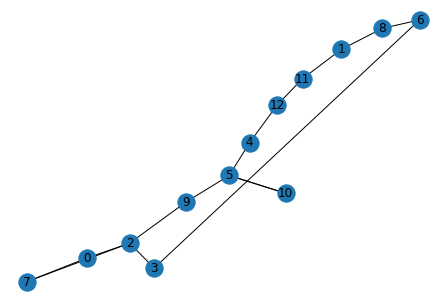

In [7]:
# 欧拉重图
def eulerian_multigraph(tree, matching):
    E = nx.MultiGraph(tree)
    for node in tree.nodes():
        E.add_node(node)
    for edge, weight in dict(nx.get_edge_attributes(matching, 'weight')).items():
        E.add_edge(edge[0], edge[1])
    return E

E = eulerian_multigraph(T, matching)
nx.draw(E, pos=nx.spring_layout(E), with_labels=True)

In [8]:
answer = list()
for tup in nx.eulerian_circuit(E):
    answer.append(tup[0])

In [9]:
t = list()
for item in answer:
    if item not in t:
        t.append(item)
print('Sloution:', t)

Sloution: [0, 2, 3, 6, 8, 1, 11, 12, 4, 5, 10, 9, 7]
